In [ ]:

#importing tensorflow modules

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt


In [ ]:
import os


In [ ]:

import pandas as pd
from copy import deepcopy
from tqdm import tqdm



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

In [ ]:
imgXtrain = np.array(x_train / 255.0, dtype='float32')
imgXtest = np.array(x_test / 255.0, dtype='float32')

In [ ]:
#35,35
height = imgXtrain.shape[1]
width = imgXtrain.shape[2]

In [ ]:
del x_train,x_test

In [ ]:

imgXtrain, imgXval = train_test_split(imgXtrain, test_size=0.2, random_state=42)

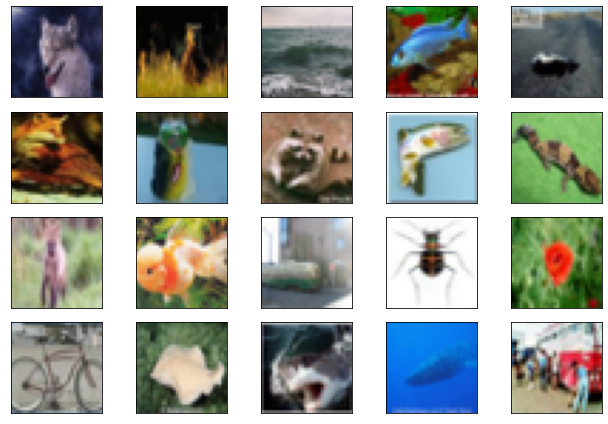

In [ ]:
plt.figure(figsize=(9,6))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(imgXtrain[i])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

# del imgX
# import gc
# gc.collect()

In [ ]:
def generate_occluded(sample):
  sample2 = deepcopy(sample)
  sample2[:,(width//2)+1 :, :] = 0
  return sample2
# generate_occluded(imgXtrain[:2])

In [ ]:


def retrieve_first_half(sample,occ):

  sample[:(width//2)+1, :] = occ[:(width//2)+1, :]



# ENCODER-DECODER Without Any Convolutional Layers

In [ ]:
IMG_SHAPE = imgXtrain.shape[1:]

In [ ]:
basic_code_size = 32

In [ ]:
def enc_dec_basic_model(IMG_SHAPE,basic_code_size):
  basic_enc = tf.keras.Sequential()
  #input layer
  basic_enc.add(tf.keras.layers.InputLayer(input_shape=IMG_SHAPE))
  #flatten the image
  basic_enc.add(tf.keras.layers.Flatten())
  #fully connected layer                  
  basic_enc.add(tf.keras.layers.Dense(basic_code_size))

  ip = tf.keras.layers.Input(IMG_SHAPE)
  encoder_op = basic_enc(ip)

  basic_dec= tf.keras.Sequential()
  basic_dec.add(tf.keras.layers.InputLayer(input_shape=(basic_code_size,)))
  basic_dec.add(tf.keras.layers.Dense(np.prod(IMG_SHAPE)))  
  #create image shape
  basic_dec.add(tf.keras.layers.Reshape(IMG_SHAPE))

  recreate_image = basic_dec(encoder_op)

  return ip,recreate_image



In [ ]:
drive_path = "/content/drive/MyDrive/ML_PROJECT"

In [ ]:
del basic_model
# import gc
# gc.collect()

In [ ]:
ip,recreate_image = enc_dec_basic_model(IMG_SHAPE,32)
basic_model = M.Model(ip,recreate_image)
basic_model.compile(optimizer='adam', loss='mse')

In [ ]:
hist1 = basic_model.fit(x=imgXtrain,y=imgXtrain, epochs=10,validation_data=(imgXval,imgXval))

Epoch 1/10
1250/1250 [==============================] - 7s 5ms/step - loss: 0.0231 - val_loss: 0.0150
Epoch 2/10
1250/1250 [==============================] - 7s 6ms/step - loss: 0.0138 - val_loss: 0.0133
Epoch 3/10
1250/1250 [==============================] - 7s 5ms/step - loss: 0.0133 - val_loss: 0.0132
Epoch 4/10
1250/1250 [==============================] - 7s 6ms/step - loss: 0.0132 - val_loss: 0.0133
Epoch 5/10
1250/1250 [==============================] - 7s 6ms/step - loss: 0.0132 - val_loss: 0.0136
Epoch 6/10
1250/1250 [==============================] - 7s 5ms/step - loss: 0.0132 - val_loss: 0.0132
Epoch 7/10
1250/1250 [==============================] - 7s 5ms/step - loss: 0.0132 - val_loss: 0.0133
Epoch 8/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0132 - val_loss: 0.0132
Epoch 9/10
1250/1250 [==============================] - 7s 6ms/step - loss: 0.0132 - val_loss: 0.0133
Epoch 10/10
1250/1250 [==============================] - 7s 6ms/step - loss: 0.013

In [ ]:
basic_model.evaluate(imgXtest,imgXtest)

313/313 [==============================] - 1s 2ms/step - loss: 0.0139


0.013878143392503262

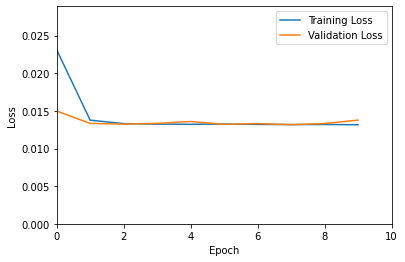

In [ ]:

epochs_range = range(10)
val_loss = hist1.history['val_loss']
tr_loss = hist1.history['loss']
plt.plot(epochs_range, tr_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, (1+0.25)*max(max(tr_loss),max(val_loss))])
plt.xlim([0, 10])

plt.legend(loc='upper right')

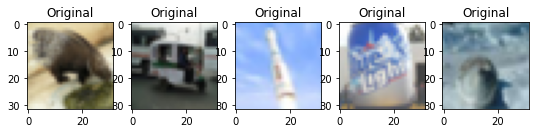

In [ ]:
plt.figure(figsize=(9,6))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.title("Original")
  plt.imshow(np.clip(imgXval[i],0,1))
plt.show()

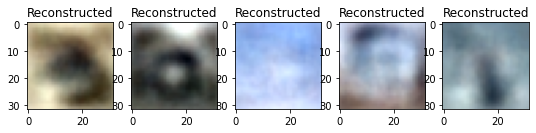

In [ ]:
plt.figure(figsize=(9,6))
for i in range(5):
  enc_op = basic_model.layers[1].predict(imgXval[i][None])[0]
  dec_op = basic_model.layers[2].predict(enc_op[None])[0]
  
  plt.subplot(2,5,i+1)
  plt.title("Reconstructed")
  plt.imshow(np.clip(dec_op,0,1))
plt.show()

In [ ]:
occXtest = generate_occluded(imgXtest)

In [ ]:
ip_64,recreate_image_64 = enc_dec_basic_model(IMG_SHAPE,64)
occ_basic_model_64 = M.Model(ip_64,recreate_image_64)
occ_basic_model_64.compile(optimizer='adam', loss='mse')

In [ ]:
tr_loss=[]
vl_loss=[]
for i in range(10):
  print("epoch : {}".format(i+1))
  occXtrain = generate_occluded(imgXtrain)
  occXval = generate_occluded(imgXval)
  l = occ_basic_model_64.fit(x=occXtrain,y=imgXtrain, epochs=1,validation_data=(occXval,imgXval))
  tr_loss.append(l.history["loss"])
  vl_loss.append(l.history["val_loss"])



epoch : 1
1250/1250 [==============================] - 6s 3ms/step - loss: 0.0317 - val_loss: 0.0256
epoch : 2
1250/1250 [==============================] - 3s 3ms/step - loss: 0.0246 - val_loss: 0.0237
epoch : 3
1250/1250 [==============================] - 3s 3ms/step - loss: 0.0237 - val_loss: 0.0234
epoch : 4
1250/1250 [==============================] - 3s 3ms/step - loss: 0.0234 - val_loss: 0.0232
epoch : 5
1250/1250 [==============================] - 3s 3ms/step - loss: 0.0232 - val_loss: 0.0230
epoch : 6
1250/1250 [==============================] - 3s 3ms/step - loss: 0.0231 - val_loss: 0.0232
epoch : 7
1250/1250 [==============================] - 3s 3ms/step - loss: 0.0230 - val_loss: 0.0240
epoch : 8
1250/1250 [==============================] - 3s 2ms/step - loss: 0.0230 - val_loss: 0.0229
epoch : 9
1250/1250 [==============================] - 3s 3ms/step - loss: 0.0230 - val_loss: 0.0242
epoch : 10
1250/1250 [==============================] - 3s 3ms/step - loss: 0.0229 - val_lo

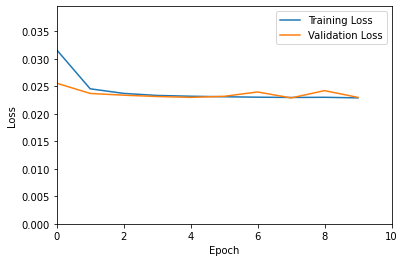

In [ ]:


epochs_range = range(10)

plt.plot(epochs_range, tr_loss, label='Training Loss')
plt.plot(epochs_range, vl_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1.25 * max(max(tr_loss),max(vl_loss))[0] ])
plt.xlim([0, 10])

plt.legend(loc='upper right')

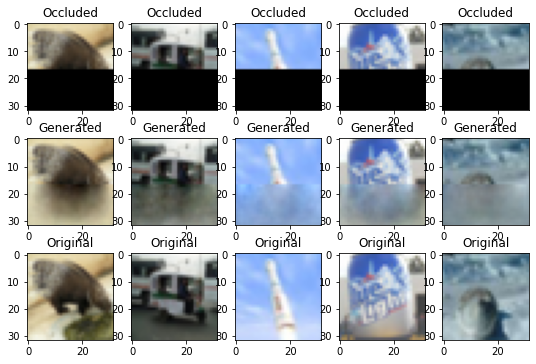

In [ ]:
plt.figure(figsize=(9,6))
for i in range(5):
  oenc_op2 = occ_basic_model_64.layers[1].predict(occXval[i][None])[0]
  odec_op2 = occ_basic_model_64.layers[2].predict(oenc_op2[None])[0]
  retrieve_first_half(odec_op2,occXval[i])
  plt.subplot(3,5,i+1)
  plt.title("Occluded")
  plt.imshow(np.clip(occXval[i],0,1))
  plt.subplot(3,5,i+6)
  plt.title("Generated")
  plt.imshow(np.clip(odec_op2,0,1))
  plt.subplot(3,5,i+11)
  plt.title("Original")
  plt.imshow(np.clip(imgXval[i],0,1))
plt.show()

In [ ]:
occ_basic_model_64.evaluate(occXtest,imgXtest)

313/313 [==============================] - 1s 2ms/step - loss: 0.0232


0.02324397675693035

## Developing deep CNN based Model

In [ ]:
def deep_cnn_model(img_shape, latent_dim):

    # encoder
    encoder = tf.keras.Sequential()
    encoder.add(tf.keras.layers.InputLayer(img_shape))
    encoder.add(tf.keras.layers.Conv2D(32, input_shape=img_shape, kernel_size=(5, 5), activation='relu', padding='same'))
    encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    encoder.add(tf.keras.layers.Conv2D(64, input_shape=img_shape[1:], kernel_size=(5, 5), activation='relu', padding='same'))
    encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    encoder.add(
        tf.keras.layers.Conv2D(128, input_shape=img_shape[1:], kernel_size=(5, 5), activation='relu', padding='same'))

    encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    encoder.add(
        tf.keras.layers.Conv2D(256, input_shape=img_shape[1:], kernel_size=(5, 5), activation='relu', padding='same'))
    encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(tf.keras.layers.Flatten())
    encoder.add(tf.keras.layers.Dense(latent_dim))

    # decoder
    decoder = tf.keras.Sequential()
    decoder.add(L.InputLayer((latent_dim,)))
    decoder.add(L.Dense(np.prod(img_shape)))
    decoder.add(L.Reshape(img_shape))

    decoder.add(L.Conv2DTranspose(128, input_shape=img_shape, kernel_size=(5, 5), activation='relu', padding='same'))

    decoder.add(L.Conv2DTranspose(64, input_shape=img_shape, kernel_size=(5, 5), activation='relu', padding='same'))

    decoder.add(L.Conv2DTranspose(32, input_shape=img_shape, kernel_size=(5, 5), activation='relu', padding='same'))

    decoder.add(L.Conv2DTranspose(3, input_shape=img_shape, kernel_size=(5, 5), activation=None, padding='same'))

    return encoder, decoder

In [ ]:
# del deep_model_32,cnn_encoder_32,cnn_decoder_32

In [ ]:
cnn_encoder_32, cnn_decoder_32 = deep_cnn_model(IMG_SHAPE, latent_dim=32)

In [ ]:

inp_32 = tf.keras.layers.Input(IMG_SHAPE)
enc_op_32 = cnn_encoder_32(inp_32)
dec_op_32 = cnn_decoder_32(enc_op_32)

deep_model_32 = tf.keras.models.Model(inp_32,dec_op_32)
deep_model_32.compile(optimizer="adamax", loss='mse')


In [ ]:
hist_32 = deep_model_32.fit(x=imgXtrain,y=imgXtrain, epochs=,validation_data=(imgXval,imgXval))

Epoch 1/15
1250/1250 [==============================] - 63s 26ms/step - loss: 0.0345 - val_loss: 0.0210
Epoch 2/15
1250/1250 [==============================] - 32s 26ms/step - loss: 0.0158 - val_loss: 0.0146
Epoch 3/15
1250/1250 [==============================] - 32s 26ms/step - loss: 0.0138 - val_loss: 0.0136
Epoch 4/15
1250/1250 [==============================] - 32s 26ms/step - loss: 0.0132 - val_loss: 0.0129
Epoch 5/15
1250/1250 [==============================] - 32s 26ms/step - loss: 0.0128 - val_loss: 0.0126
Epoch 6/15
1250/1250 [==============================] - 32s 26ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 7/15
1250/1250 [==============================] - 32s 26ms/step - loss: 0.0123 - val_loss: 0.0123
Epoch 8/15
1250/1250 [==============================] - 32s 26ms/step - loss: 0.0121 - val_loss: 0.0120
Epoch 9/15
1250/1250 [==============================] - 32s 26ms/step - loss: 0.0118 - val_loss: 0.0119
Epoch 10/15
1250/1250 [==============================] - 32s 26m

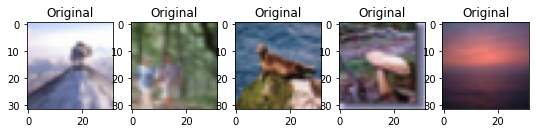

In [ ]:
plt.figure(figsize=(9,6))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.title("Original")
  plt.imshow(np.clip(imgXtest[i],0,1))
plt.show()

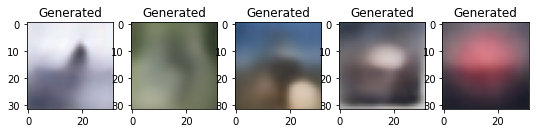

In [ ]:
plt.figure(figsize=(9,6))
for i in range(5):
  enc_op1 = cnn_encoder_32.predict(imgXtest[i][None])[0]
  dec_op1 = cnn_decoder_32.predict(enc_op1[None])[0]
  
  plt.subplot(1,5,i+1)
  plt.title("Generated")
  plt.imshow(np.clip(dec_op1,0,1))
plt.show()

In [ ]:
tf.keras.models.save_model(deep_model_32,drive_path+"/cifar_deep_model_32")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML_PROJECT/cifar_deep_model_32/assets


In [ ]:
load_32 = tf.keras.models.load_model(drive_path+"/cifar_deep_model_32")

In [ ]:
reconstruction_mse = load_32.evaluate(imgXtest, imgXtest, verbose=0)
reconstruction_mse

0.011609113775193691

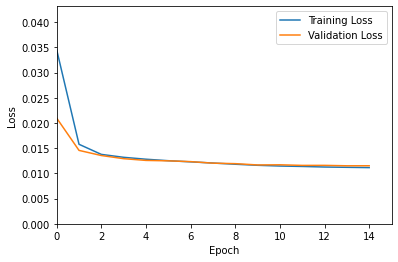

In [ ]:

epochs_range = range(15)
val_loss = hist_32.history['val_loss']
tr_loss = hist_32.history['loss']
plt.plot(epochs_range, tr_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, (1+0.25)*max(max(tr_loss),max(val_loss))])
plt.xlim([0, 15])

plt.legend(loc='upper right')

# OCCLUSION STARTS

In [ ]:
del occ_cnn_encoder_64,occ_cnn_decoder_64,occ_deep_model_64

In [ ]:
tf.keras.backend.clear_session()
occ_cnn_encoder_64, occ_cnn_decoder_64 = deep_cnn_model(IMG_SHAPE, latent_dim=64)

inp_64 = tf.keras.layers.Input(IMG_SHAPE)
occ_enc_op_64 = occ_cnn_encoder_64(inp_64)
occ_dec_op_64 = occ_cnn_decoder_64(occ_enc_op_64)

occ_deep_model_64 = tf.keras.models.Model(inp_64,occ_dec_op_64)
occ_deep_model_64.compile(optimizer="adam", loss='mse')

In [ ]:

# occXtest = generate_occluded(imgXtest)

In [ ]:
tr_loss=[]
vl_loss=[]
for i in range(10):
  print("epoch : {}".format(i+1))
  occXtrain = generate_occluded(imgXtrain)
  occXval = generate_occluded(imgXval)
  l = occ_deep_model_64.fit(x=occXtrain,y=imgXtrain, epochs=1,validation_data=(occXval,imgXval))
  tr_loss.append(l.history["loss"])
  vl_loss.append(l.history["val_loss"])

epoch : 1
1250/1250 [==============================] - 33s 26ms/step - loss: 0.0457 - val_loss: 0.0297
epoch : 2
1250/1250 [==============================] - 32s 25ms/step - loss: 0.0276 - val_loss: 0.0267
epoch : 3
1250/1250 [==============================] - 32s 25ms/step - loss: 0.0257 - val_loss: 0.0254
epoch : 4
1250/1250 [==============================] - 32s 25ms/step - loss: 0.0248 - val_loss: 0.0252
epoch : 5
1250/1250 [==============================] - 32s 25ms/step - loss: 0.0241 - val_loss: 0.0253
epoch : 6
1250/1250 [==============================] - 32s 25ms/step - loss: 0.0236 - val_loss: 0.0240
epoch : 7
1250/1250 [==============================] - 32s 25ms/step - loss: 0.0232 - val_loss: 0.0234
epoch : 8
1250/1250 [==============================] - 32s 25ms/step - loss: 0.0227 - val_loss: 0.0234
epoch : 9
1250/1250 [==============================] - 32s 25ms/step - loss: 0.0222 - val_loss: 0.0243
epoch : 10
1250/1250 [==============================] - 32s 25ms/step - l

In [ ]:
tf.keras.models.save_model(occ_deep_model_64,drive_path+"/cifar_occ_deep_model_64")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML_PROJECT/cifar_occ_deep_model_64/assets


In [ ]:
occXtest = generate_occluded(imgXtest)


In [ ]:
occ_deep_model_64.evaluate(occXtest,imgXtest)

313/313 [==============================] - 3s 9ms/step - loss: 0.0234


0.023406149819493294

In [ ]:
occ_enc_op_64

<KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'sequential')>

0.05712260492146015

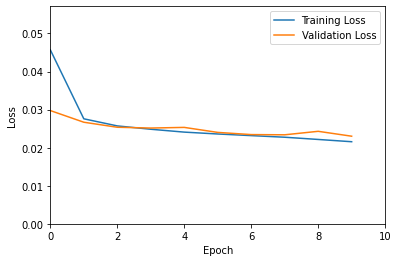

In [ ]:

epochs_range = range(10)

plt.plot(epochs_range, tr_loss, label='Training Loss')
plt.plot(epochs_range, vl_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1.25 * max(max(tr_loss),max(vl_loss))[0] ])
plt.xlim([0, 10])

plt.legend(loc='upper right')

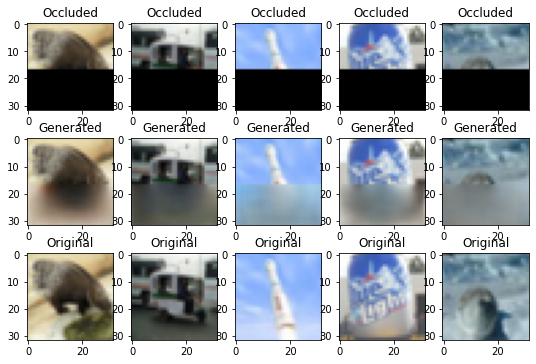

In [ ]:
plt.figure(figsize=(9,6))
for i in range(5):
  oenc_op2 = occ_cnn_encoder_64.predict(occXval[i][None])[0]
  odec_op2 = occ_cnn_decoder_64.predict(oenc_op2[None])[0]
  retrieve_first_half(odec_op2,occXval[i])
  plt.subplot(3,5,i+1)
  plt.title("Occluded")
  plt.imshow(np.clip(occXval[i],0,1))
  plt.subplot(3,5,i+6)
  plt.title("Generated")
  plt.imshow(np.clip(odec_op2,0,1))
  plt.subplot(3,5,i+11)
  plt.title("Original")
  plt.imshow(np.clip(imgXval[i],0,1))
plt.show()

In [ ]:
del occ_cnn_encoder_128,occ_cnn_decoder_128,occ_deep_model_128

CHANGE lATENT DIMS

In [ ]:
tf.keras.backend.clear_session()
occ_cnn_encoder_128, occ_cnn_decoder_128 = deep_cnn_model(IMG_SHAPE, latent_dim=128)

inp_128 = tf.keras.layers.Input(IMG_SHAPE)
occ_enc_op_128 = occ_cnn_encoder_128(inp_128)
occ_dec_op_128 = occ_cnn_decoder_128(occ_enc_op_128)

occ_deep_model_128 = tf.keras.models.Model(inp_128,occ_dec_op_128)
occ_deep_model_128.compile(optimizer="adam", loss='mse')

In [ ]:
tr_loss=[]
vl_loss=[]
for i in range(10):
  print("epoch : {}".format(i+1))
  occXtrain = generate_occluded(imgXtrain)
  occXval = generate_occluded(imgXval)
  l = occ_deep_model_128.fit(x=occXtrain,y=imgXtrain, epochs=1,validation_data=(occXval,imgXval))
  tr_loss.append(l.history["loss"])
  vl_loss.append(l.history["val_loss"])

epoch : 1
1250/1250 [==============================] - 62s 26ms/step - loss: 0.0397 - val_loss: 0.0280
epoch : 2
1250/1250 [==============================] - 32s 25ms/step - loss: 0.0273 - val_loss: 0.0275
epoch : 3
1250/1250 [==============================] - 32s 25ms/step - loss: 0.0255 - val_loss: 0.0247
epoch : 4
1250/1250 [==============================] - 32s 25ms/step - loss: 0.0247 - val_loss: 0.0245
epoch : 5
1250/1250 [==============================] - 32s 25ms/step - loss: 0.0238 - val_loss: 0.0242
epoch : 6
1250/1250 [==============================] - 32s 25ms/step - loss: 0.0232 - val_loss: 0.0232
epoch : 7
1250/1250 [==============================] - 32s 25ms/step - loss: 0.0224 - val_loss: 0.0230
epoch : 8
1250/1250 [==============================] - 32s 25ms/step - loss: 0.0219 - val_loss: 0.0226
epoch : 9
1250/1250 [==============================] - 32s 25ms/step - loss: 0.0214 - val_loss: 0.0227
epoch : 10
1250/1250 [==============================] - 32s 25ms/step - l

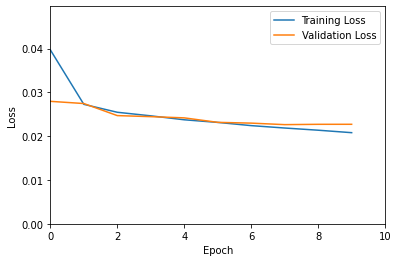

In [ ]:

epochs_range = range(10)

plt.plot(epochs_range, tr_loss, label='Training Loss')
plt.plot(epochs_range, vl_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1.25 * max(max(tr_loss),max(vl_loss))[0] ])
plt.xlim([0, 10])

plt.legend(loc='upper right')

In [ ]:
tf.keras.models.save_model(occ_deep_model_128,drive_path+"/cifar_occ_deep_model_128")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML_PROJECT/cifar_occ_deep_model_128/assets


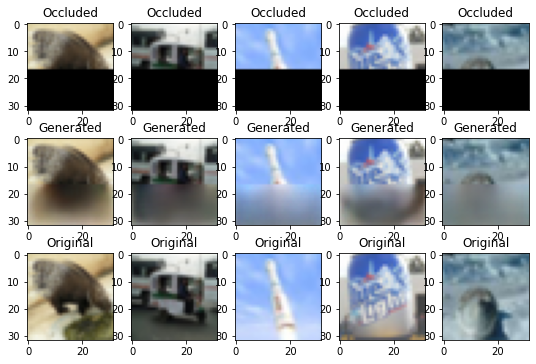

In [ ]:
plt.figure(figsize=(9,6))
for i in range(5):
  oenc_op3 = occ_cnn_encoder_128.predict(occXval[i][None])[0]
  odec_op3 = occ_cnn_decoder_128.predict(oenc_op3[None])[0]
  retrieve_first_half(odec_op3,occXval[i])
  plt.subplot(3,5,i+1)
  plt.title("Occluded")
  plt.imshow(np.clip(occXval[i],0,1))
  plt.subplot(3,5,i+6)
  plt.title("Generated")
  plt.imshow(np.clip(odec_op3,0,1))
  plt.subplot(3,5,i+11)
  plt.title("Original")
  plt.imshow(np.clip(imgXval[i],0,1))

plt.show()

In [ ]:
occ_deep_model_128.evaluate(occXtest,imgXtest)

313/313 [==============================] - 3s 9ms/step - loss: 0.0231


0.023122647777199745

In [ ]:
del occ_cnn_encoder_128,occ_cnn_decoder_128,occ_deep_model_128

In [ ]:
import gc
gc.collect()

28354

#Latent = 512

In [ ]:
# 35*35

1225

In [ ]:
tf.keras.backend.clear_session()
occ_cnn_encoder_512, occ_cnn_decoder_512 = deep_cnn_model(IMG_SHAPE, latent_dim=512)

inp_512 = tf.keras.layers.Input(IMG_SHAPE)
occ_enc_op_512 = occ_cnn_encoder_512(inp_512)
occ_dec_op_512 = occ_cnn_decoder_512(occ_enc_op_512)

occ_deep_model_512 = tf.keras.models.Model(inp_512,occ_dec_op_512)
occ_deep_model_512.compile(optimizer="adam", loss='mse')

In [ ]:
del occ_cnn_encoder_512,occ_cnn_decoder_512,occ_deep_model_512

In [ ]:
tr_loss=[]
vl_loss=[]
for epoch in range(15):
  print("epoch : {}".format(epoch+1))
  occXtrain = generate_occluded(imgXtrain)
  occXval = generate_occluded(imgXval)
  l = occ_deep_model_512.fit(x=occXtrain,y=imgXtrain, epochs=1,validation_data=(occXval,imgXval))
  tr_loss.append(l.history["loss"])
  vl_loss.append(l.history["val_loss"])

epoch : 1
1250/1250 [==============================] - 63s 26ms/step - loss: 0.0547 - val_loss: 0.0307
epoch : 2
1250/1250 [==============================] - 33s 26ms/step - loss: 0.0288 - val_loss: 0.0274
epoch : 3
1250/1250 [==============================] - 33s 26ms/step - loss: 0.0265 - val_loss: 0.0258
epoch : 4
1250/1250 [==============================] - 33s 26ms/step - loss: 0.0254 - val_loss: 0.0250
epoch : 5
1250/1250 [==============================] - 33s 26ms/step - loss: 0.0246 - val_loss: 0.0254
epoch : 6
1250/1250 [==============================] - 33s 26ms/step - loss: 0.0242 - val_loss: 0.0243
epoch : 7
1250/1250 [==============================] - 33s 26ms/step - loss: 0.0238 - val_loss: 0.0254
epoch : 8
1250/1250 [==============================] - 32s 26ms/step - loss: 0.0231 - val_loss: 0.0230
epoch : 9
1250/1250 [==============================] - 32s 26ms/step - loss: 0.0225 - val_loss: 0.0227
epoch : 10
1250/1250 [==============================] - 32s 26ms/step - l

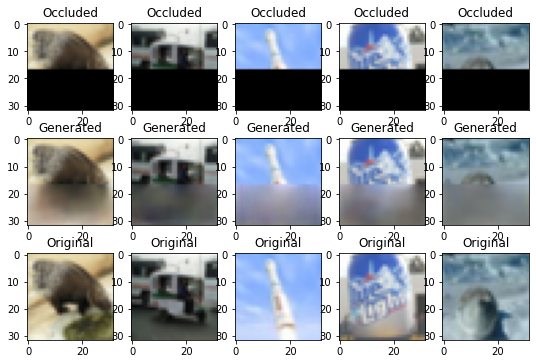

In [ ]:
plt.figure(figsize=(9,6))
for i in range(5):
  oenc_op4 = occ_cnn_encoder_512.predict(occXval[i][None])[0]
  odec_512 = occ_cnn_decoder_512.predict(oenc_op4[None])[0]
  retrieve_first_half(odec_512,occXval[i])
  plt.subplot(3,5,i+1)
  plt.title("Occluded")
  plt.imshow(np.clip(occXval[i],0,1))
  plt.subplot(3,5,i+6)
  plt.title("Generated")
  plt.imshow(np.clip(odec_512,0,1))
  plt.subplot(3,5,i+11)
  plt.title("Original")
  plt.imshow(np.clip(imgXval[i],0,1))

plt.show()

In [ ]:
tf.keras.models.save_model(occ_deep_model_512,drive_path+"/cifarocc_deep_model_512")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML_PROJECT/cifarocc_deep_model_512/assets


In [ ]:
occ_deep_model_512.evaluate(occXtest,imgXtest)

313/313 [==============================] - 3s 9ms/step - loss: 0.0228


0.022840144112706184

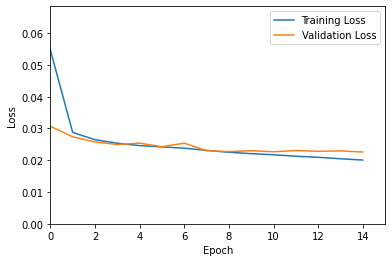

In [ ]:

epochs_range = range(15)

plt.plot(epochs_range, tr_loss, label='Training Loss')
plt.plot(epochs_range, vl_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1.25 * max(max(tr_loss),max(vl_loss))[0] ])
plt.xlim([0, 15])

plt.legend(loc='upper right')